# Re-evaluating the use of null weight in real data examples

Here with `susieR` version 0.4 I examine an example identified from simulations where SuSiE seems to have made mistakes. The data-set can be [downloaded here](http://shiny.stephenslab.uchicago.edu/gaow/susie_data/liter_data_4_summarize_ld_1_lm_less_3.rds).

In [1]:
%cd ../dsc/susie_comparison

/project/mstephens/SuSiE/mvarbvs/dsc/susie_comparison

### Conclusion

`null_weight` did help elimating the false discovery in this case example, although [on average it did not seem to help much](https://stephenslab.github.io/susie-paper/manuscript_results/numerical_results.html#Reliability-of-coverage) for CS coverage.

## Example: A "confident" mistake SuSiE has made

### The problem

In [2]:
dat = readRDS('lm_less/liter_data_4_summarize_ld_1_lm_less_3.rds')$data
r=1
fitted = susieR::susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.1, compute_univariate_zscore = TRUE,
               tol=1e-3, track_fit=TRUE)

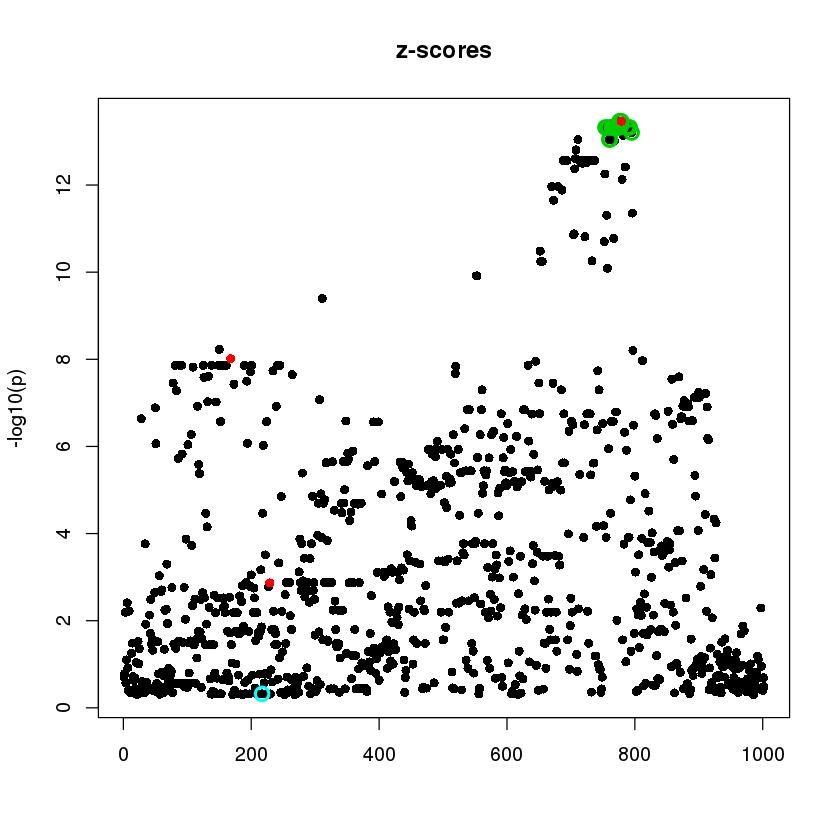

In [3]:
b = dat$true_coef[,r]
b[which(b!=0)] = 1
susieR::susie_plot(fitted, y='z', b=b, main = paste('z-scores'))

Obviously one CS in cyan it identifies is problematic. 

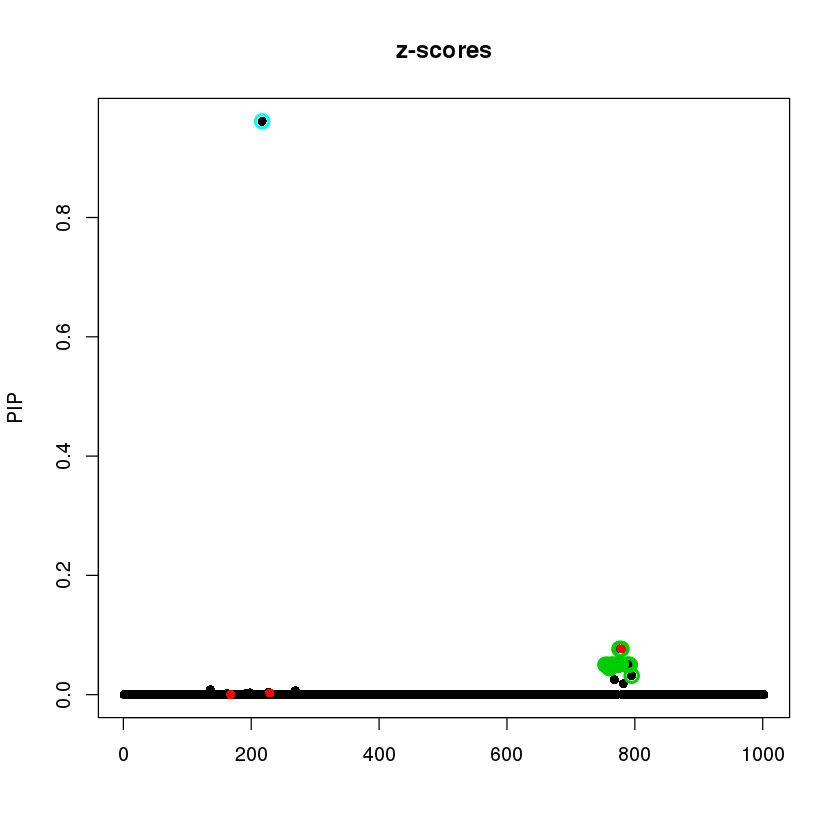

In [5]:
susieR::susie_plot(fitted, y='PIP', b=b, main = paste('z-scores'))

Let's look at the fit summary:

In [6]:
summary(fitted)$cs

cs,cs_log10bf,cs_avg_r2,cs_min_r2,variable
3,33.17007,1.000000,1.000000,217
1,94.13759,0.998824,0.995986,"754,758,760,761,764,765,769,773,774,775,776,777,778,779,788,789,792,795"


The BF is quite large. The z-score for variable 217 is quite small, though:

In [7]:
fitted$z[217]

[1] -0.05499248

The true effect sizes are:

In [8]:
cbind(dat$true_coef[,r][which(b==1)], which(b==1))

-0.2253267,168
1.0921209,229
-1.3953977,779


Where the first one is perhaps too small to pick up anyways. The observed z-scores for true causal variables are:

In [9]:
cbind(fitted$z[which(b==1)], which(b==1))

-5.617059,168
-2.998813,229
-7.489842,779


The 2nd signal, which has smallest z-score, is in fact quite close to the variable 217 SuSiE has picked up. Their correlation is:

In [11]:
cor(dat$X[,217], dat$X[,229])

[1] 0.7770304

They are highly correlated as expected. It is just a bit puzzling why SuSiE would rather pick 217 which has observed z-score of -0.05.

### Try with estimated prior

In [12]:
f2 = susieR::susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               estimate_prior_variance=TRUE, 
               compute_univariate_zscore = TRUE,
               tol=1e-3, track_fit=TRUE)

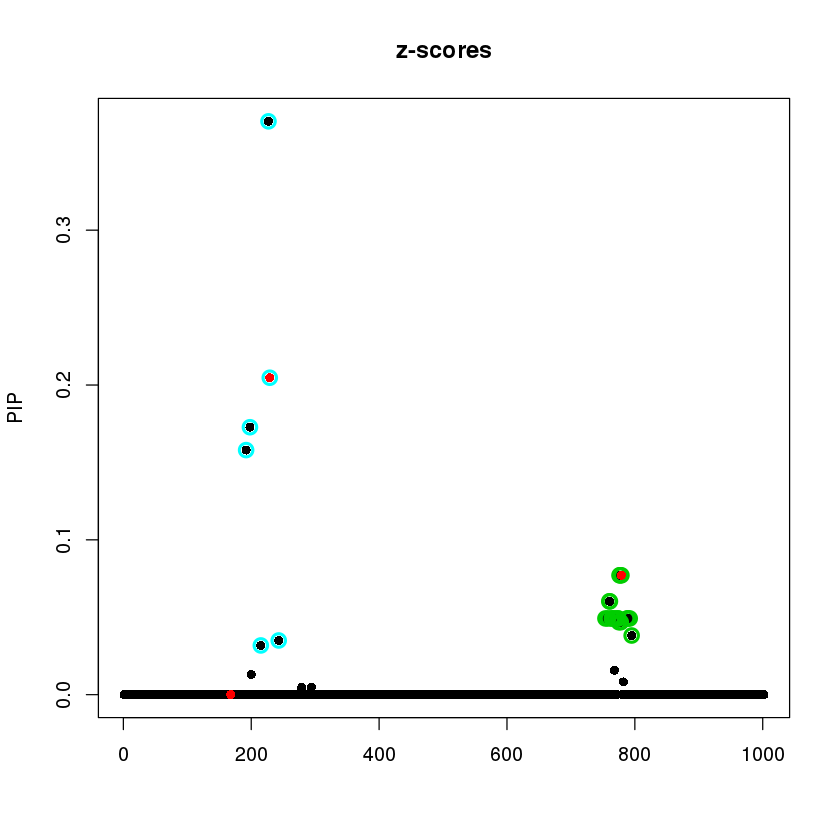

In [13]:
susieR::susie_plot(f2, y='PIP', b=b, main = paste('z-scores'))

Now SuSiE identifies two causal signals, but still not the first one. Let's see their PIP:

In [14]:
cbind(fitted$pip[which(b==1)], which(b==1))

6.661338e-16,168
2.861821e-03,229
7.659831e-02,779


PIP for the first signal is very small. But estimated prior variance are large for the 2 effects,

In [15]:
f2$V / var(dat$Y[,r])

[1] 0.574991284 0.000000000 0.284868618 0.000741383 0.000000000

In [16]:
summary(f2)$cs

cs,cs_log10bf,cs_avg_r2,cs_min_r2,variable
1,193.78532,0.9988240,0.9959860,"754,758,760,761,764,765,769,773,774,775,776,777,778,779,788,789,792,795"
3,95.33272,0.9733277,0.9391438,"192,198,215,227,229,243"


### Try set a large fixed prior

In [17]:
f22 = susieR::susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.5,
               compute_univariate_zscore = TRUE,
               tol=1e-3, track_fit=TRUE)

In [18]:
summary(f22)$cs

cs,cs_log10bf,cs_avg_r2,cs_min_r2,variable
3,38.19586,1.000000,1.000000,217
1,107.93769,0.998824,0.995986,"754,758,760,761,764,765,769,773,774,775,776,777,778,779,788,789,792,795"


It still makes a decision on including variable 217.

### Try with null weights

First, I use a small null weight (just to test the water),

In [20]:
f3 = susieR::susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.1,
               null_weight = 0.5,
               compute_univariate_zscore = TRUE,
               tol=1e-3, track_fit=TRUE)

In [21]:
summary(f3)$cs

cs,cs_log10bf,cs_avg_r2,cs_min_r2,variable
1,30.24555,0.9979646,0.9899808,"754,758,760,761,764,765,768,769,773,774,775,776,777,778,779,782,788,789,792,795"
2,10.80581,0.7911250,0.3237647,"253,317,458,477,480,487,498,512,524,538,541,560,572,594,601,606,609,626,627,672,703,721"


Interestingly it now picks **another irrelevant CS**. Although it has a small BF, compared to the BF with null variable it is still a lot larger. That is, **a small penalty does not help but made it worse**.

The BF for set involving the null variable is small compared to others.

In [22]:
f3$lbf

[1] 30.245553 10.805811  2.793260  2.790408  2.754368

Now I increase the null penalty,

In [23]:
f4 = susieR::susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.1,
               null_weight = 0.9,
               compute_univariate_zscore = TRUE,
               tol=1e-3, track_fit=TRUE)

In [24]:
summary(f4)$cs

cs,cs_log10bf,cs_avg_r2,cs_min_r2,variable
1,28.1656,0.9943364,0.956193,"753,754,758,760,761,764,765,768,769,773,774,775,776,777,778,779,782,785,788,789,792,795"


It seems the problematic variable is removed. I now try to trick `summary` to display more information just to checkout how it helped,

In [25]:
f4$null_index=0
f4$sets = susieR::susie_get_CS(f4, cbind(dat$X,0), min_abs_corr=0)
summary(f4)$cs

cs,cs_log10bf,cs_avg_r2,cs_min_r2,variable
3,3.011818,1.0000000,1.00000000,1003
1,28.165605,0.9943364,0.95619299,"753,754,758,760,761,764,765,768,769,773,774,775,776,777,778,779,782,785,788,789,792,795"
2,11.554834,0.5869098,0.08081462,"136,162,217,253,317,477,480,487,498,512,524,538,541,560,572,594,601,606,609,626,627,672,703,721"


In [26]:
f4$lbf

[1] 28.165605 11.554834  3.011818  3.010324  3.008291

Notice that with the use of null variable, the previously "wrong" variable 217 now ends up in a CS with purity of 0.08, thus not selected. The null variable itself forms a separate CS, though, with a small BF.